In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [199]:
import datasets 

import numpy as np
import os
import time
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence

if torch.cuda.is_available():  
  use_cuda = True
else:  
  use_cuda = False

# Data

In [4]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


# Preprocessing

In [5]:
#remove unnecessary information
df.drop(df.iloc[:, 15:131], inplace=True, axis=1)
df = df.drop(["annotator_id"], axis=1)

#rescale annotated scores from (0,5) to (0,1)
import pandas as pd
df_need_to_rescale = df.drop(["comment_id", "hate_speech_score", "text"], axis=1)
df_norm = (df_need_to_rescale-df_need_to_rescale.min())/(df_need_to_rescale.max()-df_need_to_rescale.min())
df_norm = pd.concat((df.comment_id, df_norm, df.hate_speech_score, df.text), 1)

<ipython-input-5-2aaeed172fa0>:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_norm = pd.concat((df.comment_id, df_norm, df.hate_speech_score, df.text), 1)


In [ ]:
GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words

# Data Loading

In [6]:
df_norm

,comment_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text
0,47777,1.000000,0.00,0.00,0.00,0.00,0.50,0.0,0.00,0.00,0.00,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...
1,39773,0.666667,0.00,0.00,0.00,0.00,0.50,0.0,0.00,0.00,0.50,0.0,-6.52,The trans women reading this tweet right now i...
2,47101,1.000000,1.00,1.00,1.00,1.00,1.00,1.0,0.00,0.00,1.00,1.0,0.36,Question: These 4 broads who criticize America...
3,43625,1.000000,0.50,0.75,0.50,0.25,0.50,0.0,0.00,0.00,0.75,0.0,0.26,It is about time for all illegals to go back t...
4,12538,0.000000,1.00,1.00,1.00,1.00,1.00,1.0,1.00,0.25,0.75,1.0,1.54,For starters bend over the one in pink and kic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,37080,0.666667,0.25,0.25,0.00,0.00,0.50,0.0,0.00,0.00,0.50,0.0,-4.88,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...
135552,22986,0.666667,0.50,0.00,0.00,0.00,0.50,0.0,0.00,0.00,0.25,0.0,-4.40,Millions of #Yemen-is participated in mass ral...
135553,21008,0.666667,0.25,0.25,0.25,0.25,0.25,0.0,0.00,0.00,0.25,0.0,-2.49,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
135554,22986,0.666667,0.50,0.00,0.00,0.00,0.50,0.0,0.00,0.00,0.50,0.0,-4.40,Millions of #Yemen-is participated in mass ral...


In [32]:
df_spliced = df_norm.drop('comment_id', axis=1)
df_spliced = df_spliced.drop('platform', axis=1)
df_spliced = df_spliced.drop('sentiment', axis=1)
df_spliced = df_spliced.drop('hatespeech', axis=1)
df_spliced = df_spliced.drop('hate_speech_score', axis=1)

In [61]:
tweets = df_spliced.iloc[:,-1:]

In [139]:
labels = df_spliced.iloc[:,:-1]

In [140]:
labels = labels.to_numpy()

In [207]:
label_names = list(df_spliced.iloc[:,:-1].columns)

In [87]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [102]:
train_size = int(0.7*len(df_spliced))
val_size = int((len(df_spliced) - train_size)/2)
test_size = len(df_spliced) - train_size - val_size

In [103]:
train_size

94889

In [104]:
val_size

20333

In [105]:
test_size

20334

In [141]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for index, row in tweets.iterrows():
            tweet = row[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(labels[index]).long()
            if index < train_size:
                train.append((idxs, label))
            elif index < train_size+val_size:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(GLOVE)

In [155]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad
  
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, collate_fn=pad_collate)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True, collate_fn=pad_collate)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True, collate_fn=pad_collate)

# Helpers

In [162]:
###############################################################################
# For Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Models

In [173]:
""" EPAI Class Models
This file contains the class objects for RNN, BiRNN, LSTM, BiLSTM and GRU.
"""
import gensim.downloader
import torch
from torch import nn
import torchtext

# global variables
# GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words
# WORD2VEC = gensim.downloader.load("word2vec-google-news-300")

class Tweet_RNN(nn.Module):
    """
    The class object for the RNN.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # Tweet_RNN.__init__(self, input_size, hidden_size, num_classes)
    # param: self:Tweet_RNN
    # param: input_size:int
    # param: hidden_size:int
    # param: num_classes:int
    # param: embedding:str
    #    the string should be either: "glove", "word2vec" or "none"
    #    and correspond to the desired embedding
    # return: void
    # initializes the RNN
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, embedding: str) -> None:
        super(Tweet_RNN, self).__init__()
        self.name = 'Tweet_RNN'
        if embedding == "glove":
            self.emb = nn.Embedding.from_pretrained(GLOVE.vectors)
        elif embedding == "word2vec":
            self.emb = nn.Embedding.from_pretrained(WORD2VEC)
        else:
            self.emb = nn.Embedding(input_size, num_classes)
        self.hidden_size = hidden_size
        self.nn = nn.RNN(input_size, hidden_size, batch_first=True)
        # self.linear = nn.Linear(input_size, 1);
        self.linear = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    # forward(self, x)
    # param: self:Tweet_RNN
    # param: x:torch.FloatTensor
    # initializes the RNN
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.nn(x, h0)

        # Pass the output of hidden layer from the last time step to the classifier
        out = self.sigmoid(self.linear(out[:, -1, :])) #sigmoid activiation is applyed for all 8 classes

        return out #outputs a tensor of dimension 8 


class Tweet_BiRNN(nn.Module):
    """
    The class object for the BiRNN.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # Tweet_BiRNN.__init__(self, input_size, hidden_size, num_classes)
    # param: self:Tweet_BiRNN
    # param: input_size:int
    # param: hidden_size:int
    # param: num_classes:int
    # param: embedding:str
    #    the string should be either: "glove", "word2vec" or "none"
    #    and correspond to the desired embedding
    # return: void
    # initializes the BiRNN
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, embedding: str) -> None:
        super(Tweet_BiRNN, self).__init__()
        self.name = 'Tweet_BiRNN'
        if embedding == "glove":
            self.emb = nn.Embedding.from_pretrained(GLOVE.vectors)
        elif embedding == "word2vec":
            self.emb = nn.Embedding.from_pretrained(WORD2VEC)
        else:
            self.emb = nn.Embedding(input_size, num_classes)
        self.hidden_size = hidden_size
        self.nn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sigmoid()

    # forward(self, x)
    # param: self:Tweet_BiRNN
    # param: x:torch.FloatTensor
    # initializes the BiRNN
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.nn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


class Tweet_LSTM(nn.Module):
    """
    The class object for the LSTM.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # Tweet_LSTM.__init__(self, input_size, hidden_size, num_classes)
    # param: self:Tweet_LSTM
    # param: input_size:int
    # param: hidden_size:int
    # param: num_classes:int
    # param: embedding:str
    #    the string should be either: "glove", "word2vec" or "none"
    #    and correspond to the desired embedding
    # return: void
    # initializes the LSTM
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, embedding: str) -> None:
        super(Tweet_LSTM, self).__init__()
        self.name = 'Tweet_LSTM'
        if embedding == "glove":
            self.emb = nn.Embedding.from_pretrained(GLOVE.vectors)
        elif embedding == "word2vec":
            self.emb = nn.Embedding.from_pretrained(WORD2VEC)
        else:
            self.emb = nn.Embedding(input_size, num_classes)
        self.hidden_size = hidden_size
        self.nn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sigmoid()

    # forward(self, x)
    # param: self:Tweet_LSTM
    # param: x:torch.FloatTensor
    # return: out:torch.FloatTensor
    # initializes the LSTM
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.nn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


class Tweet_BiLSTM(nn.Module):
    """
    The class object for the BiLSTM.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # Tweet_BiLSTM.__init__(self, input_size, hidden_size, num_classes)
    # param: self:Tweet_BiLSTM
    # param: input_size:int
    # param: hidden_size:int
    # param: num_classes:int
    # param: embedding:str
    #    the string should be either: "glove", "word2vec" or "none"
    #    and correspond to the desired embedding
    # return: void
    # initializes the BiLSTM
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, embedding: str) -> None:
        super(Tweet_BiLSTM, self).__init__()
        self.name = 'Tweet_BiLSTM'
        if embedding == "glove":
            self.emb = nn.Embedding.from_pretrained(GLOVE.vectors)
        elif embedding == "word2vec":
            self.emb = nn.Embedding.from_pretrained(WORD2VEC)
        else:
            self.emb = nn.Embedding(input_size, num_classes)
        self.hidden_size = hidden_size
        self.nn = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sigmoid()

    # forward(self, x)
    # param: self:Tweet_BiLSTM
    # param: x:torch.FloatTensor
    # return: out:torch.FloatTensor
    # initializes the BiLSTM
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the BiLSTM
        out, _ = self.nn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

class Tweet_GRU(nn.Module):
    """
    The class object for the GRU.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # Tweet_GRU.__init__(self, input_size, hidden_size, num_classes)
    # param: self:Tweet_GRU
    # param: input_size:int
    # param: hidden_size:int
    # param: num_classes:int
    # param: embedding:str
    #    the string should be either: "glove", "word2vec" or "none"
    #    and correspond to the desired embedding
    # return: void
    # initializes the GRU
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, embedding: str) -> None:
        super(Tweet_GRU, self).__init__()
        self.name = 'Tweet_GRU'
        if embedding == "glove":
            self.emb = nn.Embedding.from_pretrained(GLOVE.vectors)
        elif embedding == "word2vec":
            self.emb = nn.Embedding.from_pretrained(WORD2VEC)
        else:
            self.emb = nn.Embedding(input_size, num_classes)
        self.hidden_size = hidden_size
        self.nn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sigmoid()

    # forward(self, x)
    # param: self:Tweet_GRU
    # param: x:torch.FloatTensor
    # return: out:torch.FloatTensor
    # initializes the GRU
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the GRU
        out, _ = self.nn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

# Training

In [208]:
def get_accuracy(net, loader, label_names):
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs)
        labels.float()
        classification_report(
            labels,
            outputs,
            output_dict=False,
            target_names=label_names
        )
    return

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs)
        loss_func = nn.BCELoss()
        loss = loss_func(outputs, labels.float())
        loss.backward()
    return_loss = float(loss)
    return return_loss
   
def train_net(net, train_loader, val_loader, batch_size=150, learning_rate=0.005, num_epochs=6):
    # Define the Loss function and optimizer
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        i=0
        for text, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
              text = text.cuda()
              labels = labels.cuda()
              net = net.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(text)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            i=i+1
        train_loss[epoch] = float(loss)
        # train_acc[epoch] = get_accuracy(net, train_loader, label_names)
        train_acc[epoch] = 0
        # val_acc[epoch] = get_accuracy(net, valid_loader, label_names)
        val_acc[epoch] = 0
        val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} | "+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch+1)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [188]:
model = Tweet_RNN(50, 8, 2, 'glove')

In [197]:
train_net(model, train_loader, valid_loader, batch_size=512, learning_rate=0.01, num_epochs=10)

Epoch 1: Train acc: 0.0, Train loss: 0.499738872051239 | Validation acc: 0.0, Validation loss: 0.8496906161308289
Epoch 2: Train acc: 0.0, Train loss: 0.47432318329811096 | Validation acc: 0.0, Validation loss: 0.8644119501113892
Epoch 3: Train acc: 0.0, Train loss: 0.48845914006233215 | Validation acc: 0.0, Validation loss: 0.8292258977890015
Epoch 4: Train acc: 0.0, Train loss: 0.44749918580055237 | Validation acc: 0.0, Validation loss: 0.8558497428894043
Epoch 5: Train acc: 0.0, Train loss: 0.4961223006248474 | Validation acc: 0.0, Validation loss: 0.8395687341690063
Epoch 6: Train acc: 0.0, Train loss: 0.4881030321121216 | Validation acc: 0.0, Validation loss: 0.928481936454773
Epoch 7: Train acc: 0.0, Train loss: 0.4652864933013916 | Validation acc: 0.0, Validation loss: 0.8582598567008972
Epoch 8: Train acc: 0.0, Train loss: 0.46586668491363525 | Validation acc: 0.0, Validation loss: 0.8754505515098572
Epoch 9: Train acc: 0.0, Train loss: 0.507645308971405 | Validation acc: 0.0, 

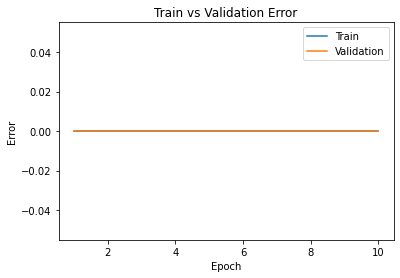

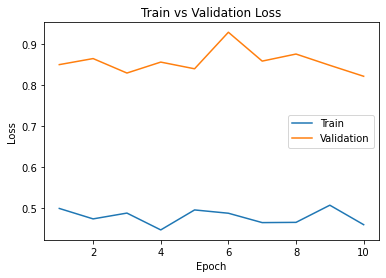

In [198]:
plot_training_curve(get_model_name(model.name, 512, 0.01, 10))

# need tuning, nltk preprocessing too with stemming probs
# why tf is training loss also not decreasing
# and need to implement confusion matrix method of calculating acc